# Figure 1c
This notebook creates the figure that wass used for Figure 1C in the main manuscript. Note that the labels and appearance of the Figure were optimized with a graphics software to improve the appearance of the published figure.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from kcet import Wordvec2Cosine

The constructor of ``Wordvec2Cosine`` loads the word embeddings and words into a pandas dataframe.

In [6]:
data_directory = input()

/home/peter/data/pubmed2vec


In [17]:
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df = w2c.get_embeddings()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388


## MeSH terms representing Lung and Ovarian neoplasms

Note that we transform ids such as "D008175" to "meshd008175" to conform with the way PubTator labels the concepts.

In [18]:
data = [['D008175', 'Lung Neoplasms'],['D000077192','Adenocarcinoma of Lung'],
        ['D002282','Adenocarcinoma, Bronchiolo-Alveolar'],
        ['D001984', 'Bronchial Neoplasms'], ['D002283','Carcinoma, Bronchogenic'],
        ['D002289','Carcinoma, Non-Small-Cell Lung'],['D055752', 'Small Cell Lung Carcinoma'],
        ['D000086002', 'Mesothelioma, Malignant'],['D055613', 'Multiple Pulmonary Nodules'],
        ['D010178', 'Pancoast Syndrome'],['D018202', 'Pulmonary Blastoma'],
        ['D047868', 'Pulmonary Sclerosing Hemangioma']]
df_lung = pd.DataFrame(data, columns = ['MeSH descriptor','Preferred label'])
df_lung['MeSH descriptor'] = df_lung['MeSH descriptor'].apply(lambda meshid: "meshd" + meshid[1:])
df_lung.head()

,MeSH descriptor,Preferred label
0,meshd008175,Lung Neoplasms
1,meshd000077192,Adenocarcinoma of Lung
2,meshd002282,"Adenocarcinoma, Bronchiolo-Alveolar"
3,meshd001984,Bronchial Neoplasms
4,meshd002283,"Carcinoma, Bronchogenic"


In [19]:
data = [['D010051', 'Ovarian Neoplasms'],['D000077216', 'Carcinoma, Ovarian Epithelial'],
['D001948', 'Brenner Tumor'],['D006106', 'Granulosa Cell Tumor'],
['D008539', 'Meigs Syndrome'],['D013798', 'Thecoma'],
['D018269', 'Carcinoma, Endometrioid'],['D018310', 'Sertoli-Leydig Cell Tumor'],
['D018311', 'Luteoma'],['D061325', 'Hereditary Breast and Ovarian Cancer Syndrome']]
df_ovarian = pd.DataFrame(data, columns = ['MeSH descriptor','Preferred label'])
df_ovarian['MeSH descriptor'] = df_ovarian['MeSH descriptor'].apply(lambda meshid: "meshd" + meshid[1:])
df_ovarian.head()

,MeSH descriptor,Preferred label
0,meshd010051,Ovarian Neoplasms
1,meshd000077216,"Carcinoma, Ovarian Epithelial"
2,meshd001948,Brenner Tumor
3,meshd006106,Granulosa Cell Tumor
4,meshd008539,Meigs Syndrome


The following code extracts the vectors for the above concepts.

In [22]:
terms_ovarian = []
for term in df_ovarian['MeSH descriptor']:
    if term in df.index:
        terms_ovarian.append(term)   
ovarian_descendant_df = df.loc[terms_ovarian]
ovarian_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd010051,3.072791,-2.909225,2.060097,4.283984,5.044001,3.521364,-2.625771,2.760182,0.359268,-5.208926,...,-2.067533,4.287587,5.239411,-2.756318,-4.954819,6.051542,-4.532008,0.841578,0.163029,7.852741
meshd000077216,2.953218,-2.924506,2.235753,3.520408,5.433797,2.701469,-3.294727,2.832772,1.040954,-4.847880,...,-2.014151,3.565517,5.502385,-2.904055,-4.857262,6.737767,-4.803393,1.434961,0.291188,7.652975
meshd001948,2.114845,-3.445855,1.451699,1.565399,3.261432,3.478113,-2.297478,1.319301,-0.269439,-4.683348,...,-1.149413,3.438398,3.891533,-1.993584,-2.719943,3.982745,-4.441090,0.150367,0.339359,6.288504
meshd006106,2.453123,-3.225351,2.230294,2.072668,3.829018,3.777840,-2.520633,2.707639,0.578923,-4.629045,...,-1.835440,4.750452,4.482211,-2.425702,-3.002339,4.658401,-4.252470,1.110849,0.992910,7.294141
meshd008539,0.803067,-1.330232,0.654609,1.323322,1.445127,1.163081,-1.423022,0.913188,0.238121,-1.911834,...,-0.472482,1.530111,1.661097,-1.086506,-1.399170,1.991800,-1.244199,0.338743,0.002728,3.760147


In [23]:
terms_lung = []
for term in df_lung['MeSH descriptor']:
    if term in df.index:
        terms_lung.append(term)   
lung_descendant_df = df.loc[terms_lung]
lung_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd008175,3.301751,-4.811779,1.622228,3.851357,2.915498,3.848569,-1.740700,3.183929,0.596785,-5.987088,...,-2.284585,2.975377,5.520432,-2.285758,-3.951332,4.657407,-2.712857,2.580101,0.411148,8.063503
meshd000077192,2.997698,-3.973783,1.934827,3.786742,3.882792,2.959357,-3.569564,3.366140,0.440438,-5.279186,...,-2.126046,3.113032,4.836854,-1.511266,-4.918917,4.884159,-2.259126,2.374165,0.852736,8.293936
meshd002282,2.848512,-4.879909,1.697816,2.488158,2.931847,3.718457,-3.378844,2.231766,-0.157493,-5.216762,...,-1.753302,3.810427,3.903719,-1.857803,-2.950452,4.999865,-2.031033,1.436844,0.751334,8.629610
meshd001984,2.519319,-4.371069,1.705905,2.400935,2.940546,3.295285,-2.396487,1.487975,0.182894,-3.873713,...,-1.255919,3.557224,3.611812,-1.619412,-3.240314,4.556928,-2.965185,1.523867,0.663890,6.811733
meshd002283,3.088353,-4.984658,1.933589,4.056807,4.116179,4.154083,-2.441550,1.894567,0.454660,-5.440371,...,-2.264604,3.463539,5.413669,-1.648129,-3.218199,4.859321,-3.000702,2.721330,0.339338,8.232040


In [24]:
# Define list of colors for plotting.
cvec = ["blue"] * len(terms_lung) + ["green"]* len(terms_ovarian)
print(cvec)

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']


In [26]:
lung_ovarian_df = pd.concat([lung_descendant_df, ovarian_descendant_df])

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(lung_ovarian_df.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6817227  0.11548049 0.06351165]


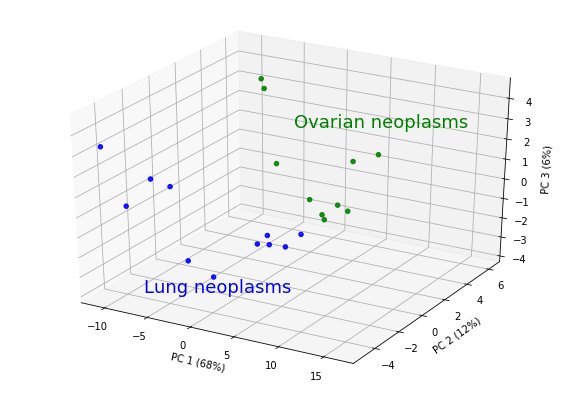

In [39]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], color = cvec,alpha=0.9)
#plt.title("3D scatter plot")
ax.set_xlabel('PC 1 (%.f%%)' % (pca.explained_variance_ratio_[0]*100)) 
ax.set_ylabel('PC 2 (%.f%%)' % (pca.explained_variance_ratio_[1]*100)) 
ax.set_zlabel('PC 3 (%.f%%)' % (pca.explained_variance_ratio_[2]*100))

ax.text(-2, 4, 2, 'Ovarian neoplasms', color='green', size=18)
ax.text(-8, -4, -4, 'Lung neoplasms', color='blue', size=18)
# show plot
plt.show()